In [9]:
#read excell file
import pandas as pd
import fitter
import matplotlib.pyplot as plt
import scipy.stats as stats
import dill
import numpy as np


In [10]:
#read excell file
#header is on row 3
df = pd.read_excel('./je-d-01.05.04.01.01.xlsx', header=2,sheet_name="Einwanderungen")
#cut off after row 49
df = df[:49]
#cut off row 2 to 24
df = df.drop(df.index[2:25])
#set first column as index
df = df.set_index(df.columns[0])

#replace * with nan
df = df.apply(pd.to_numeric, errors='coerce')
#keep only the following indexes
df = df.loc[['Total','Deutschland', 'Österreich', 'Schweizer', 'Frankreich', 'Italien']]
#Transpose the dataframe
df = df.T

df["Deutsch"] = df["Deutschland"] + df["Österreich"] + df["Schweizer"]
df["Andere"] = df["Total"] - df["Deutsch"] - df["Frankreich"] - df["Italien"]
#drop Columns Total Deutschland Österreich Schweizer 
df = df.drop(df.columns[0:4], axis=1)
#rename Frankreich to Französisch
df = df.rename(index=str, columns={"Frankreich": "Französisch"})
#rename Italien to Italienisch
df = df.rename(index=str, columns={"Italien": "Italienisch"})

In [11]:
def display_distributions_cdf(f:fitter.Fitter, data:list, plotName:str, cost_method:str):
    best_distributions_names = f.summary(plot=False, method=cost_method).index.values[:6]

    sorted_data = data.copy()
    sorted_data.sort()

    y_data = []

    for i in range(len(sorted_data)):
        y_data.append(i / len(sorted_data))

    _, ax = plt.subplots(1, 1, figsize = (10,10))

    ax.plot(sorted_data, y_data, label = "original")

    for distribution_name in best_distributions_names:
        obj = getattr(stats, distribution_name)
        params = f.fitted_param[distribution_name]

        if type(params) is dict:
            params = list(params.values())

        x_dist_vals = np.linspace(sorted_data[0], sorted_data[-1], 1000)
        dist_vals = obj.cdf(x_dist_vals, *params)

        ax.plot(x_dist_vals, dist_vals, label=distribution_name)

    ax.set_title(plotName + " best dist: " + list(f.get_best(method=cost_method).keys())[0])
    ax.legend()
    plt.show()

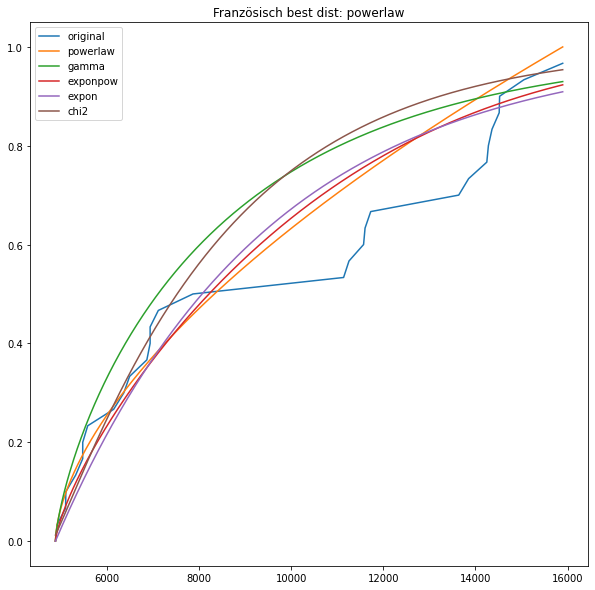

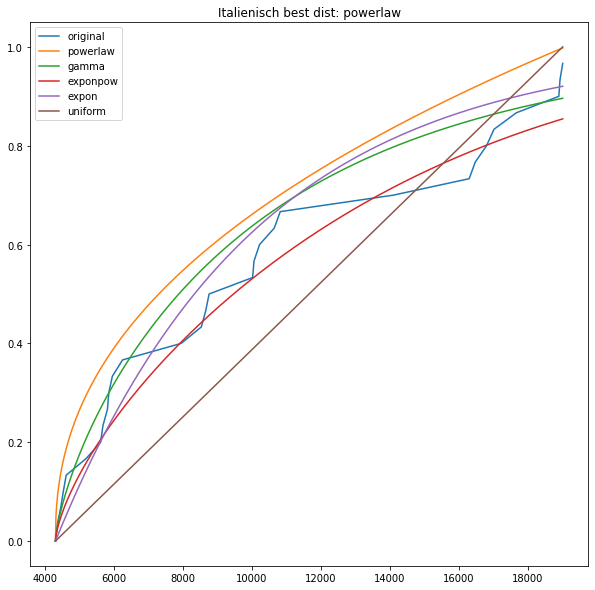

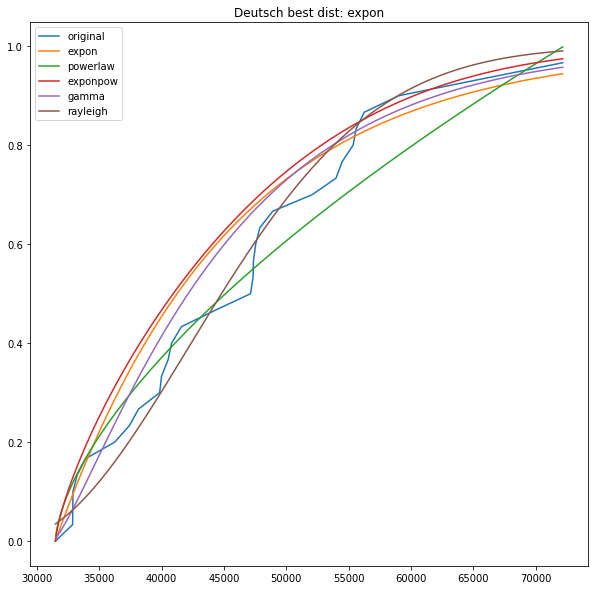

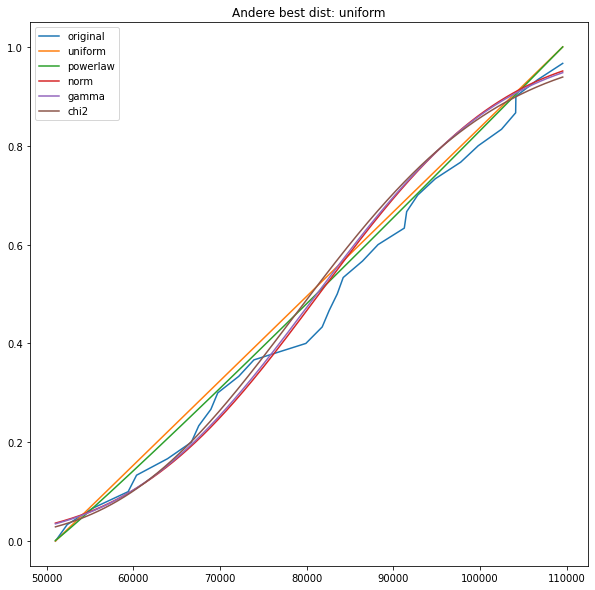

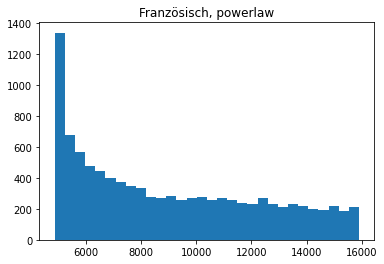

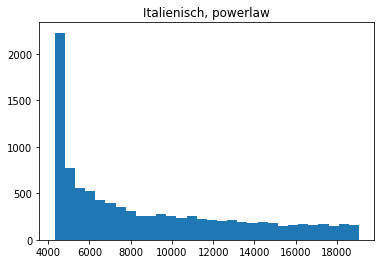

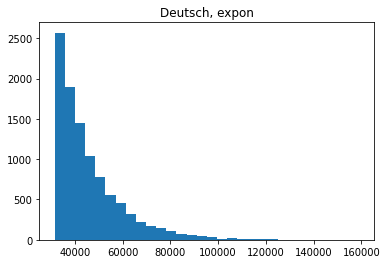

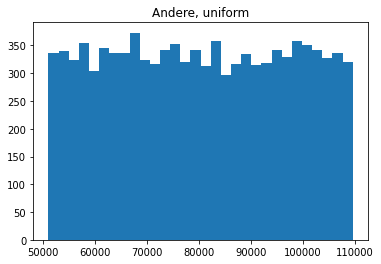

{'Französisch': {'powerlaw': {'a': 0.5972845912678386, 'loc': 4879.999999999999, 'scale': 11018.251678052946}}, 'Italienisch': {'powerlaw': {'a': 0.4343924590236491, 'loc': 4313.999999999999, 'scale': 14757.953230060544}}, 'Deutsch': {'expon': {'loc': 31489.0, 'scale': 14075.73333333333}}, 'Andere': {'uniform': {'loc': 51004.0, 'scale': 58553.0}}}


In [12]:
#for each column find the best fit distribution
dict_distributions = {}
for col in df.columns:
    #fit the data and drop na
    f = fitter.Fitter(df[col].dropna(), timeout=60,distributions=fitter.get_common_distributions())
    f.fit()

    method = "sumsquare_error"
    dict_distributions[col] = f.get_best(method=method)

    display_distributions_cdf(f, df[col].dropna().values, col, method)

for sprache, dist in dict_distributions.items():
    obj = getattr(stats, list(dist.keys())[0])
    params = dist[list(dist.keys())[0]]

    if type(params) is dict:
        params = list(params.values())

    dist_vals = obj.rvs(size=10000, *params)

    plt.hist(dist_vals, bins=30)
    plt.title(sprache + ", " + str(list(dist.keys())[0]))
    plt.show()
    
print(dict_distributions)
    

In [13]:
dill.dump(dict_distributions, open("distributions_nach_sprache.pick", mode='wb'))